# Análise de Séries Temporais
## Aula 6

In [39]:
## Pacotes
# 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 
from econometric_functions import ols_reg
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.stats.diagnostic import breaks_cusumolsresid
from statsmodels.regression.recursive_ls import RecursiveLS

# General
from IPython.display import clear_output
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

import plotly.graph_objects as go

In [4]:
## Quartely
df_quart = pd.read_csv("quarterly.csv")
df_quart_s = df_quart[['S']]

# Filtrando 
df_quart_f = df_quart[df_quart['Date'] <= '2012-10-01']

#
df_quart_f_s = df_quart_f[['S']]

#
array_quart_s = np.array(df_quart_f_s) 

## ARMA vs OLS

A estimação via ARMA (Máxima Verossimilhança) e via OLS(Mínimos quadrados) apersar de serem bem similares possuem estimadores diferentes. Observando os dois modelos estimados abaixo, percebe-se que não são significantes diferente do modelo com os autorregressores, o via OLS não possui os coeficientes de $S_{-5}$ e $S_{-7}$ significantes a 5\%.

In [5]:
# Lista com as variáveis AR (autorregressores) e MA (Média Móvel)
lista_ar = list(range(1,10))
lista_ma = 0

# Modelo autorregressivo 1

arma_mod = ARIMA(array_quart_s, order = (lista_ar,0,lista_ma), trend = 'c')
model = arma_mod.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  212
Model:                 ARIMA(9, 0, 0)   Log Likelihood                -132.338
Date:                Mon, 28 Mar 2022   AIC                            286.675
Time:                        08:24:26   BIC                            323.598
Sample:                             0   HQIC                           301.598
                                - 212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1998      0.163      7.378      0.000       0.881       1.519
ar.L1          1.1059      0.070     15.817      0.000       0.969       1.243
ar.L2         -0.4192      0.106     -3.963      0.0

In [6]:
#
variables_to_keep = ['Date', 'S', 'D_S']
my_data = df_quart_f[variables_to_keep]

my_data.index = pd.DatetimeIndex(my_data.Date)
my_data = my_data[['S', 'D_S']]

#
for i in range(1,10):
    globals()[f"s_lag_{i}"] = my_data[['S']].shift(i)
    pdList = []
    pdList.extend(value for name,
                  value in locals().items() if name.startswith('s_lag_'))
    df_merged = pd.concat(pdList, axis = 1)
    
for j in  range(0,9):
    newcolumns = df_merged.columns.values
    newcolumns[j] = f"s_lag_{j+1}"

#
my_data = pd.merge(my_data, df_merged, on='Date', how='right', copy=False,
                   sort=False, suffixes=('','')) 

In [7]:
mod_lag = ols_reg('S ~ s_lag_1+s_lag_2+s_lag_3+s_lag_4+s_lag_5+s_lag_6+s_lag_7+s_lag_8+s_lag_9', my_data)

                            OLS Regression Results                            
Dep. Variable:                      S   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     75.50
Date:                Mon, 28 Mar 2022   Prob (F-statistic):           2.06e-58
Time:                        08:24:31   Log-Likelihood:                -129.12
No. Observations:                 203   AIC:                             278.2
Df Residuals:                     193   BIC:                             311.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2550      0.067      3.779      0.0

Modelo não é estivável por OLS, porque para estimar o MA acima é necessário ter a variável dependente e os regressores, e como em OLS conhecemos os regressores depois, portanto não é aplicável em OLS.

$$ y_t= E_t +\beta E_{t-1} \rightarrow MA(1)$$

Portanto, não existe estimação de MA em OLS, contudo há formas recursivas de obter esses valores.
$$OLS \rightarrow \hat{E_{t}}$$

$$ y_{t} = \hat{E}_{t} + \beta \hat{E}_{t-1} + u_t $$

AR(1) $\rightarrow$ ARMA
$$ y_{t} = \rho_0 + \rho_1y_{t-1}+E_t $$
de modo que
$$ y_{t-1} = \rho_0 + \rho_1y_{t-2}+E_{t-1} $$

Obs.:
- Para este caso, a estimação por OLS não é eficiente;
- Utilizar a estimação via OLS apenas quando não for possível realizar certo testes, como o de CUSUM.

## Teste de CUSUM

In [8]:
my_data = my_data.dropna()

#
endog = my_data[['S']]
variables = ['s_lag_1', 's_lag_2', 's_lag_3', 's_lag_4', 's_lag_5', 's_lag_6', 's_lag_7', 's_lag_8', 's_lag_9']
exog = sm.add_constant(my_data[variables])

#
mod_break = RecursiveLS(endog=endog, exog=exog)
mod_break = mod_break.fit()
print(mod_break.summary())

                           Statespace Model Results                           
Dep. Variable:                      S   No. Observations:                  203
Model:                    RecursiveLS   Log Likelihood                -157.422
Date:                Mon, 28 Mar 2022   R-squared:                       0.779
Time:                        08:24:36   AIC                            334.843
Sample:                    04-01-1962   BIC                            367.976
                         - 10-01-2012   HQIC                           348.247
Covariance Type:            nonrobust   Scale                            0.220
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2550      0.067      3.779      0.000       0.123       0.387
s_lag_1        1.1127      0.071     15.716      0.000       0.974       1.251
s_lag_2       -0.4244      0.106     -4.010      0.0

C:\Users\CLIENTE\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
C:\Users\CLIENTE\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


Com base no teste de CUSUM abaixo, não foi possível rejeitar a hipótese nula de que não há quebra estrutural no modelo.

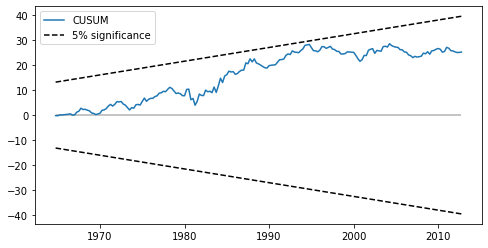

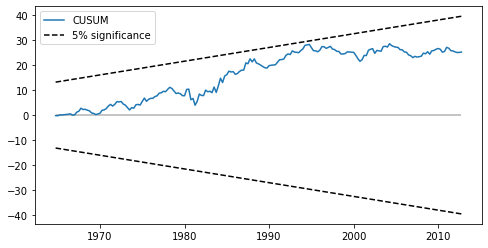

In [9]:
mod_break.plot_cusum(figsize=(8,4))

## Previsões
### Modelo

In [10]:
# Modelo utilizado em sala
lista_ar = [1]
lista_ma = [1,2,7]

# Modelo acima com o intercepto
arma_mod = ARIMA(array_quart_s, order = (lista_ar,0,lista_ma), trend = 'c')
mod_arima = arma_mod.fit()
print(mod_arima.summary())

                                 SARIMAX Results                                  
Dep. Variable:                          y   No. Observations:                  212
Model:             ARIMA(1, 0, [1, 2, 7])   Log Likelihood                -137.295
Date:                    Mon, 28 Mar 2022   AIC                            286.591
Time:                            08:24:51   BIC                            306.730
Sample:                                 0   HQIC                           294.731
                                    - 212                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1946      0.198      6.034      0.000       0.807       1.583
ar.L1          0.8375      0.049     17.163      0.000       0.742       0.933
ma.L1          0.311

C:\Users\CLIENTE\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


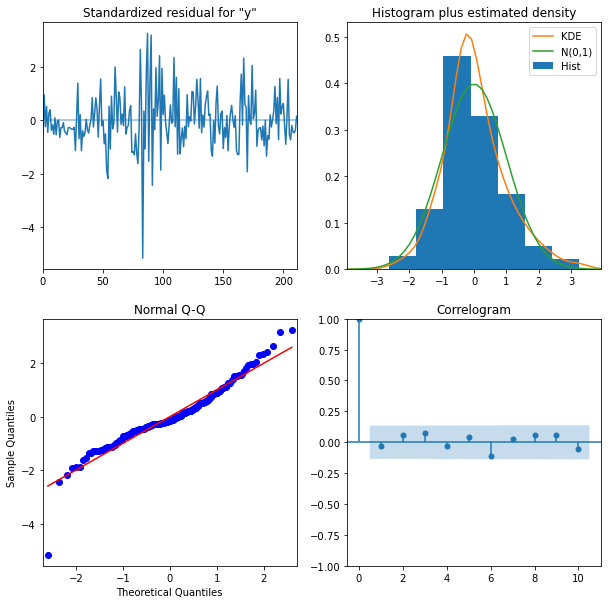

In [11]:
# Plots
mod_arima.plot_diagnostics(figsize=(10, 10))
plt.show()

# ACF e PACF dos resíduos 
#res_acf = acf(mod_arima.resid, nlags = 12, qstat = True)
#res_pacf = pacf(mod_arima.resid, nlags = 12, method = "ywm")

### Estimando previsões

[Text(0.5, 1.0, 'Predicted Values'),
 Text(0, 0.5, 'Indice'),
 Text(0.5, 0, 'Ano')]

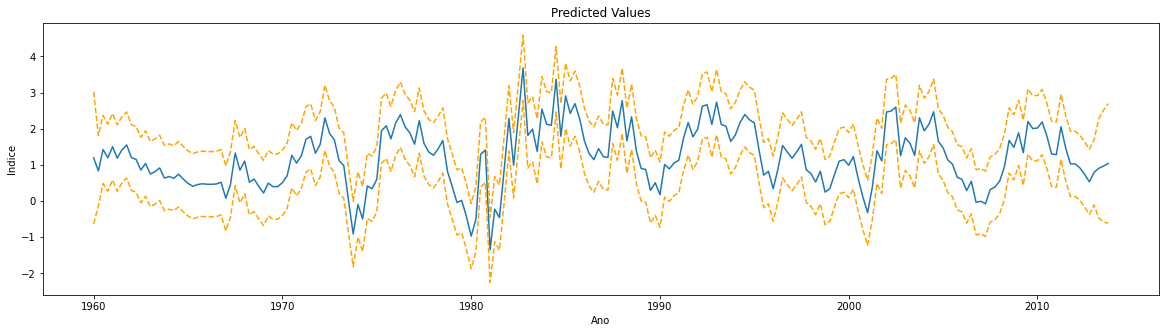

In [12]:
# Predict: Dynamic False
predict_results = mod_arima.get_prediction(start = 0,
                                           end = 215)

# DF com os valores previstos + IC
pred_summary = predict_results.summary_frame()
pred_summary['Date'] = pd.date_range(start='1960-01-01',
                                     end='2013-10-01',
                                     freq='3MS')

# Gráfico
fig, ax = plt.subplots(figsize = (20,5)) 

ax.plot(pred_summary['Date'], pred_summary['mean'])
ax.plot(pred_summary['Date'], pred_summary['mean_ci_upper'],
        color = 'orange', linestyle='dashed')
ax.plot(pred_summary['Date'], pred_summary['mean_ci_lower'],
        color = 'orange', linestyle='dashed')
ax.set(title='Predicted Values', ylabel='Indice', xlabel='Ano')

Se o método de previsão for dinâmico (`dynamic=True`) teremos que a curva de previsões convergirá para a média de longo prazo série, porque diferente de quando o modelo for estático (`dynamic=False`) ele utilizará os valores previstos da série não os valores observados. Logo, como esses resultados "não possuem erro" ~alguma coisa~.

In [ ]:
# Predict: Dynamic True
# Problemática
predict_results = mod_arima.get_prediction(start = 7, # O valor do start deve estar de acordo com o valor do MA()
                                           end = 215,
                                           dynamic=True)
# DF com os valores previstos + IC
pred_summary = predict_results.summary_frame()
pred_summary['Date'] = pd.date_range(start='1961-10-01', # O mesmo vale para este start
                                     end='2013-10-01',
                                     freq='3MS')
# Gráfico 
fig, ax = plt.subplots(figsize = (20,5)) 

ax.plot(pred_summary['Date'], pred_summary['mean'])
ax.plot(pred_summary['Date'], pred_summary['mean_ci_upper'],
        color = 'orange', linestyle='dashed')
ax.plot(pred_summary['Date'], pred_summary['mean_ci_lower'],
        color = 'orange', linestyle='dashed')
ax.set(title='Predicted Values', ylabel='Indice', xlabel='Ano')


## Exemplo Aula: Produção Industrial EUA


In [72]:
# Filtrando 
df_quart_f = df_quart[df_quart['Date'] <= '2012-10-01']

# Selecionando variável de interesse
df_ppinsa = df_quart_f[['PPINSA']]

# Diferenciando variável de interesse
df_ppinsa_diff = df_ppinsa.diff().dropna()

Perceptível que a série possue raiz unitária 

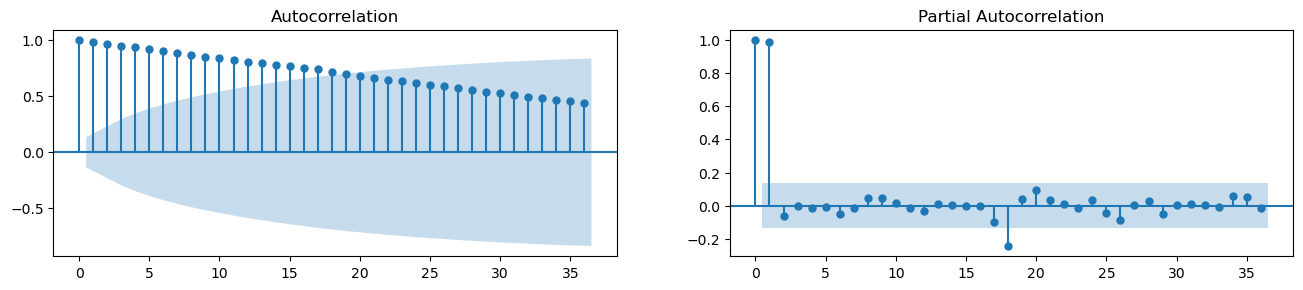

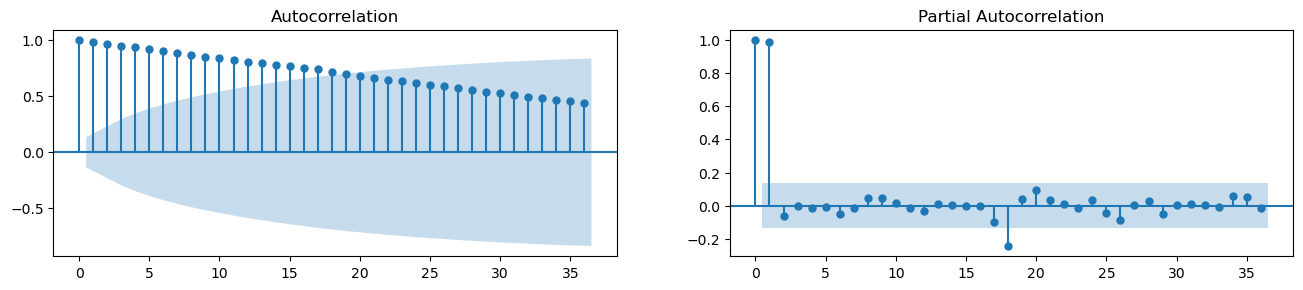

In [76]:
fig, axes = plt.subplots(1,2, figsize=(16,3), dpi= 100)

plot_acf(df_ppinsa, lags=36, ax=axes[0])
plot_pacf(df_ppinsa, lags=36, ax=axes[1])

In [67]:
resultado_acf = acf(df_ppinsa, nlags = 36, qstat = True)
resultado_pacf = pacf(df_ppinsa, nlags = 36, method = "ywm")

list_acf = list(resultado_acf)
AC = list_acf[0]
AC = list(AC)
AC.remove(AC[0])

list_pacf= list(resultado_pacf)
list_pacf.remove(list_pacf[0])

headerColor = 'grey'
rowEvenColor = 'lightgrey'
rowOddColor = 'white'

fig = go.Figure(data=[go.Table(header=dict(values=['n','AC', 'PAC', 'Q-Stat', 'Prob'],
                                          line_color='darkslategray',
                                          fill_color=headerColor,
                                          align=['left','center'],
                                          font=dict(color='white', size=12)),
                               cells=dict(values=[list(range(1,37)),AC, list_pacf, list_acf[1], list_acf[2]],
                                          fill_color = [[rowOddColor,rowEvenColor]*18],
                                          align = ['left', 'center'],
                                          font = dict(color = 'darkslategray', size = 12)))
                     ])
fig.show()

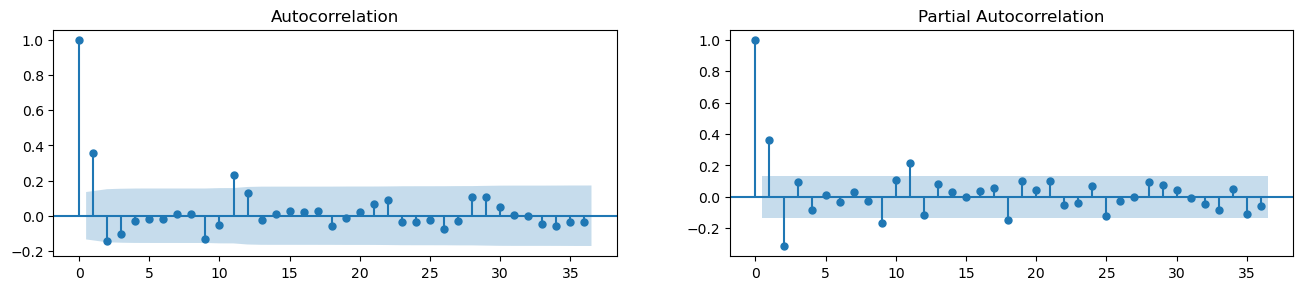

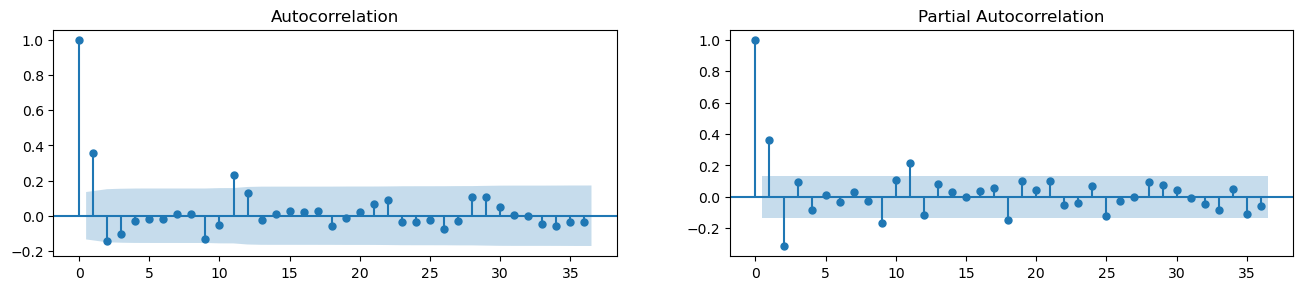

In [77]:
fig, axes = plt.subplots(1,2, figsize=(16,3), dpi= 100)

plot_acf(df_ppinsa_diff, lags=36, ax=axes[0])
plot_pacf(df_ppinsa_diff, lags=36, ax=axes[1])

In [79]:
resultado_acf = acf(df_ppinsa_diff, nlags = 36, qstat = True, fft = False)
resultado_pacf = pacf(df_ppinsa_diff, nlags = 36, method = "ywm")

list_acf = list(resultado_acf)
AC = list_acf[0]
AC = list(AC)
AC.remove(AC[0])

list_pacf= list(resultado_pacf)
list_pacf.remove(list_pacf[0])

headerColor = 'grey'
rowEvenColor = 'lightgrey'
rowOddColor = 'white'

fig = go.Figure(data=[go.Table(header=dict(values=['n','AC', 'PAC', 'Q-Stat', 'Prob'],
                                          line_color='darkslategray',
                                          fill_color=headerColor,
                                          align=['left','center'],
                                          font=dict(color='white', size=12)),
                               cells=dict(values=[list(range(1,37)),AC, list_pacf, list_acf[1], list_acf[2]],
                                          fill_color = [[rowOddColor,rowEvenColor]*18],
                                          align = ['left', 'center'],
                                          font = dict(color = 'darkslategray', size = 12)))
                     ])
fig.show()

In [93]:
# Log
df_lppinsa = np.log(df_ppinsa['PPINSA'])
df_lppinsa = df_lppinsa.diff().dropna()
array_lppinsa_diff = np.asarray(df_lppinsa)

# Lista com as variáveis AR (autorregressores) e MA (Média Móvel)
lista_ar = list(range(1,3)) + [11]
lista_ma = 0

# Modelo autorregressivo 1

arma_mod = ARIMA(array_lppinsa_diff, order = (lista_ar,0,lista_ma), trend = 'c')
model = arma_mod.fit()
print(model.summary())

                                  SARIMAX Results                                  
Dep. Variable:                           y   No. Observations:                  211
Model:             ARIMA([1, 2, 11], 0, 0)   Log Likelihood                 582.268
Date:                     Mon, 28 Mar 2022   AIC                          -1154.537
Time:                             10:05:39   BIC                          -1137.777
Sample:                                  0   HQIC                         -1147.762
                                     - 211                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0086      0.003      2.731      0.006       0.002       0.015
ar.L1          0.4883      0.090      5.415      0.000       0.312       0.665
ar.L2       

[Text(0.5, 1.0, 'Valores previstos d(log(PPINSA))'),
 Text(0, 0.5, 'Indice'),
 Text(0.5, 0, 'Ano')]

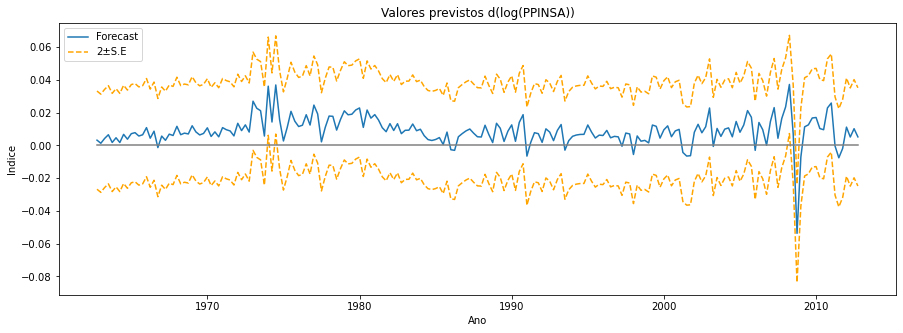

In [106]:
# Forecasting model
predict_results = model.get_prediction(start = 11, end = 211)

# DF com os valores previstos + IC
pred_summary = predict_results.summary_frame()
pred_summary['Date'] = pd.date_range(start='1962-10-01',
                                     end='2012-10-01',
                                     freq='3MS')
zarray = np.zeros(201)

# Gráfico

fig, ax = plt.subplots(figsize = (15,5)) 

ax.plot(pred_summary['Date'], pred_summary['mean'], label='Forecast')
ax.plot(pred_summary['Date'], pred_summary['mean_ci_upper'],
        color = 'orange', linestyle='dashed', label='2±S.E')
ax.plot(pred_summary['Date'], pred_summary['mean_ci_lower'],
        color = 'orange', linestyle='dashed')
ax.plot(pred_summary['Date'], zarray, color = 'gray')
ax.legend()
ax.set(title='Valores previstos d(log(PPINSA))', ylabel='Indice', xlabel='Ano')

## Combinação de previsões
Não achei nada específico em python, imagino seja somente os modelos estimados, por algum dos métodos apresentados em sala, como variáveis independentes e o a variável observada como independente